# MLX Omni Server: Embeddings API Example

This notebook demonstrates how to use the OpenAI-compatible Embeddings API endpoint with MLX Omni Server.

With MLX Omni Server, you can generate embeddings locally on your Apple Silicon device using a variety of models.

## Setup

First, let's import the OpenAI client and configure it to use our local MLX Omni Server instance.

In [7]:
from openai import OpenAI
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Configure client to use local server
client = OpenAI(
    base_url="http://localhost:10240/v1",  # Point to local server
    api_key="not-needed",  # API key is not required for local server
)

## Generate Embeddings for a Single Text

Let's start by generating embeddings for a single piece of text.

In [8]:
# Generate embedding for a single text
response = client.embeddings.create(
    model="mlx-community/all-MiniLM-L6-v2-4bit", input="I like reading"
)

# Examine the response structure
print(f"Response type: {type(response)}")
print(f"Model used: {response.model}")
print(f"Embedding dimension: {len(response.data[0].embedding)}")

Response type: <class 'openai.types.create_embedding_response.CreateEmbeddingResponse'>
Model used: mlx-community/all-MiniLM-L6-v2-4bit
Embedding dimension: 384


## v1/chat/embeddings

### Testing Embeddings API with Curl

You can directly test the embeddings endpoint using curl, as follows:

```shell
curl http://localhost:10240/v1/embeddings \
  -H "Content-Type: application/json" \
  -d '{
    "model": "mlx-community/all-MiniLM-L6-v2-4bit",
    "input": ["Hello world!", "Embeddings are useful for semantic search."]
  }'
```

This will return a JSON response with the embeddings for each input text.

### Visualize a Few Dimensions of the Embedding

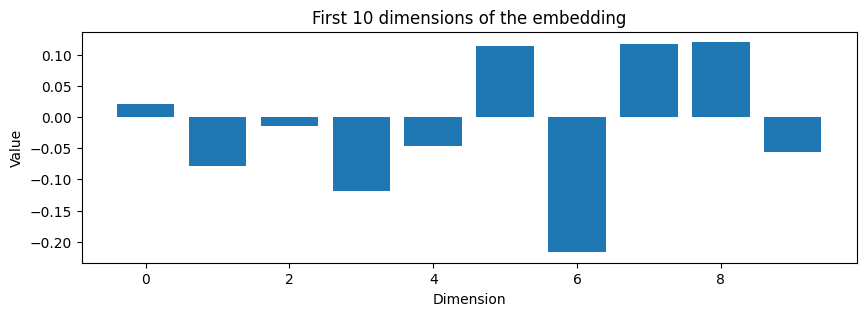

In [9]:
# Visualize first 10 dimensions of the embedding
embedding = response.data[0].embedding[:10]
plt.figure(figsize=(10, 3))
plt.bar(range(len(embedding)), embedding)
plt.title("First 10 dimensions of the embedding")
plt.xlabel("Dimension")
plt.ylabel("Value")
plt.show()

## Generate Embeddings for Multiple Texts

The API can efficiently generate embeddings for multiple texts in a single request.

In [10]:
# Multiple texts to embed
texts = [
    "I like reading fiction books.",
    "The weather is nice today.",
    "Neural networks are a type of machine learning model.",
    "I enjoy reading science books.",
]

# Generate embeddings for multiple texts
response = client.embeddings.create(
    model="mlx-community/all-MiniLM-L6-v2-4bit", input=texts
)

# Create a list of embeddings
embeddings = [item.embedding for item in response.data]
print(f"Generated {len(embeddings)} embeddings of dimension {len(embeddings[0])}")

Generated 4 embeddings of dimension 384


## Semantic Search Example

One of the most common uses of embeddings is semantic search. Let's demonstrate a simple example:

In [11]:
# Convert embeddings to numpy arrays for easier manipulation
embeddings_np = np.array(embeddings)

# Generate embedding for a query
query = "I love to read books"
query_response = client.embeddings.create(
    model="mlx-community/all-MiniLM-L6-v2-4bit", input=query
)
query_embedding = np.array(query_response.data[0].embedding)

# Calculate cosine similarity between the query and all texts
similarities = cosine_similarity([query_embedding], embeddings_np)[0]

# Create a DataFrame to display results
results = pd.DataFrame({"Text": texts, "Similarity": similarities})

# Sort by similarity (highest first)
results = results.sort_values("Similarity", ascending=False)
results

,Text,Similarity
0,I like reading fiction books.,0.916941
3,I enjoy reading science books.,0.815611
2,Neural networks are a type of machine learning...,0.781193
1,The weather is nice today.,0.759635


## Text Clustering Example

Let's try clustering similar texts using their embeddings.

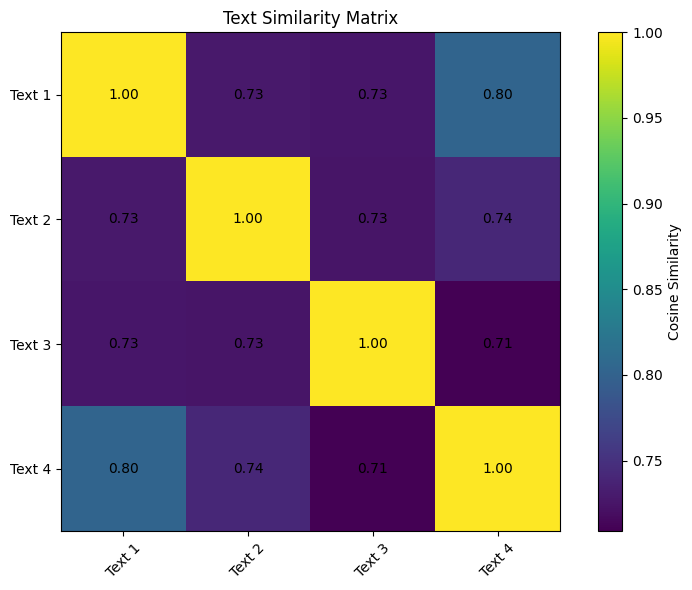

In [12]:
# Generate a similarity matrix
similarity_matrix = cosine_similarity(embeddings_np)

# Visualize the similarity matrix
plt.figure(figsize=(8, 6))
plt.imshow(similarity_matrix, cmap="viridis")
plt.colorbar(label="Cosine Similarity")
plt.title("Text Similarity Matrix")
plt.xticks(range(len(texts)), [f"Text {i+1}" for i in range(len(texts))], rotation=45)
plt.yticks(range(len(texts)), [f"Text {i+1}" for i in range(len(texts))])
for i in range(len(texts)):
    for j in range(len(texts)):
        plt.text(
            j,
            i,
            f"{similarity_matrix[i, j]:.2f}",
            ha="center",
            va="center",
            color="white" if similarity_matrix[i, j] < 0.7 else "black",
        )
plt.tight_layout()
plt.show()